In [ ]:
from google.colab import  drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

### Dodwnloading the dataset using API command.

In [ ]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

potato-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzipped the dataset
import zipfile
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Potato Leaf Diseease Classification/potato-leaf-disease-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

## Importing the necessary libraries.

In [ ]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.models import Model

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
train_data = keras.utils.image_dataset_from_directory(
    directory = '/content/Potato/Train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_data = keras.utils.image_dataset_from_directory(
    directory = '/content/Potato/Valid',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    shuffle = False,
    image_size=(256,256)
)
test_data = keras.utils.image_dataset_from_directory(
    directory = '/content/Potato/Test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    shuffle = True,
    image_size=(256,256)
)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
# Normalize
def norm(image,label):

  '''
  This is a helping function for normalizing the images.
  It takes the images as input and scale down the images pixel values between 0 and 1.
  '''

  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_data = train_data.map(norm)
validation_data = validation_data.map(norm)

In [ ]:
os.listdir('/content/Potato')

['Train', 'Test', 'Valid']

In [ ]:
class_names = sorted(os.listdir('/content/Potato/Train'), reverse=False)


In [ ]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Displaying some random images of different classes

(32, 256, 256, 3)
[0 2 0 2 1 0 2 2 2 0 2 0 0 2 2 2 0 2 0 1 2 0 0 1 2 1 1 2 1 1 2 0]


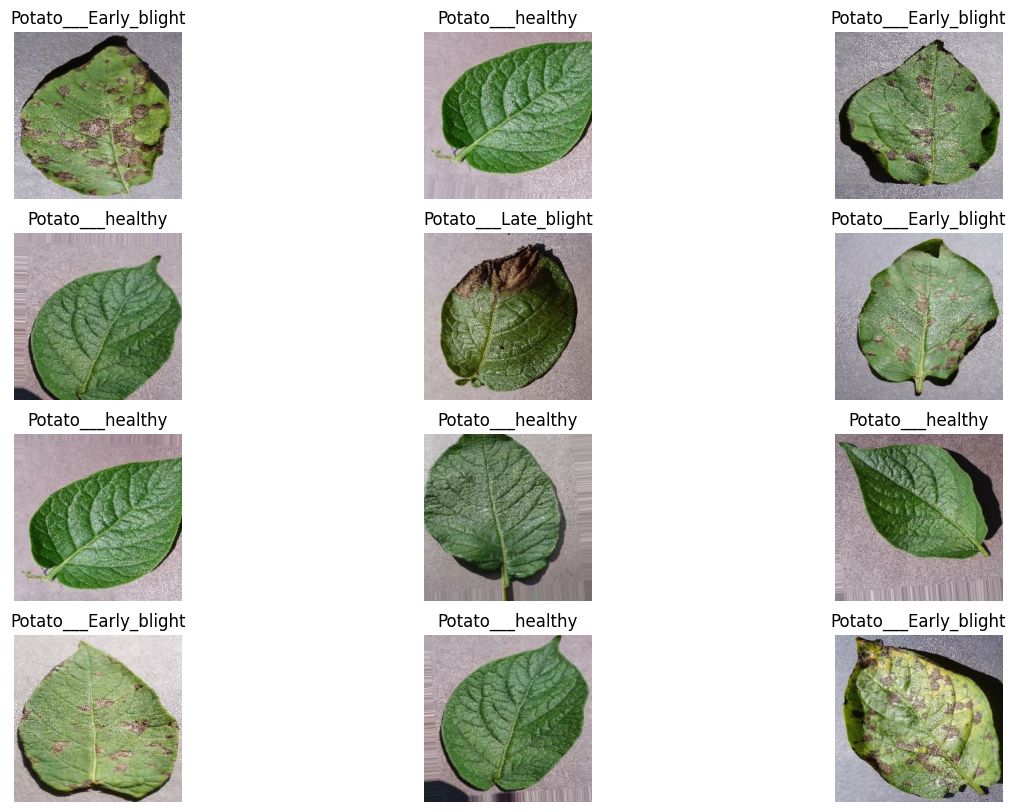

In [ ]:

plt.figure(figsize=(15,10))
for image,labels in test_data.take(1):
  print(image.shape)
  print(labels.numpy())
  for i in range(12):
    ax=plt.subplot(4,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.show()

## Building a simple CNN model with 50 epochs

In [ ]:
model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(3,activation='softmax'))

In [ ]:
# compiling the model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#getting the summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 256)      

# Early Stopping
##### Early Stopping is an optimizing technique which is used to stop the training when the model cannot perform the better.

In [ ]:

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.1,
    patience=0,
    verbose=1,
    mode="auto",
    baseline=None
)

In [ ]:
history = model.fit(
    train_data,
    epochs = 20,
    batch_size = 32,
    verbose = 1,
    validation_data = validation_data,
    callbacks=[early_stopping]

)

Epoch 1/20
29/29 [==============================] - 8s 160ms/step - loss: 1.8370 - accuracy: 0.4500 - val_loss: 0.7452 - val_accuracy: 0.5100
Epoch 2/20
29/29 [==============================] - 4s 147ms/step - loss: 0.5342 - accuracy: 0.7844 - val_loss: 0.4221 - val_accuracy: 0.8600
Epoch 3/20
29/29 [==============================] - 5s 162ms/step - loss: 0.2942 - accuracy: 0.8856 - val_loss: 0.2682 - val_accuracy: 0.8733
Epoch 4/20
29/29 [==============================] - 5s 157ms/step - loss: 0.1778 - accuracy: 0.9378 - val_loss: 0.2591 - val_accuracy: 0.9033
Epoch 4: early stopping


In [ ]:
test_loss=model.evaluate(validation_data)[0]
test_accuracy=model.evaluate(validation_data)[1]

10/10 [==============================] - 0s 41ms/step - loss: 0.2591 - accuracy: 0.9033


In [ ]:
results = model.evaluate(validation_data, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.25914
Test Accuracy: 90.33%


## Plotting the loss of the model

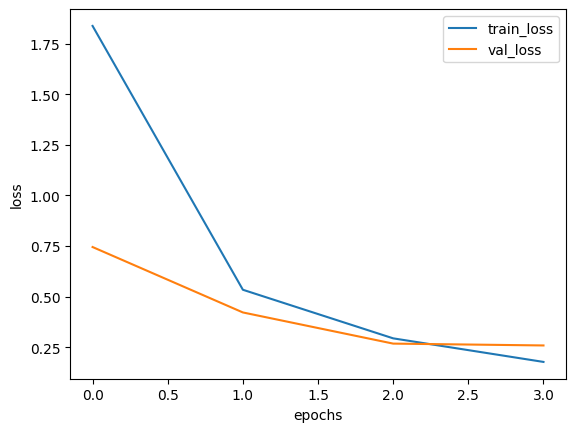

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## plotting the accuracy of the model

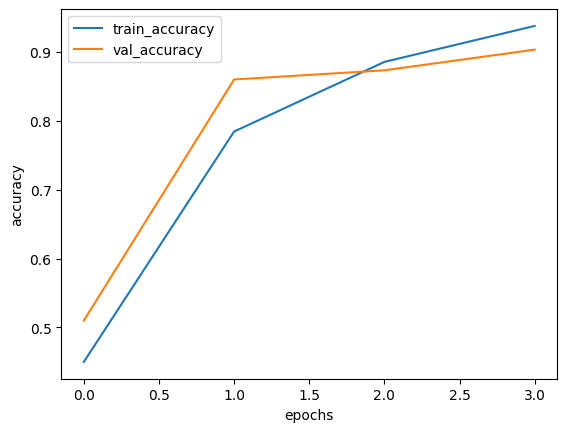

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Building the model using data augmentation technique

In [ ]:


datagen=ImageDataGenerator( rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5])

In [ ]:
# Create a data generator for the train,test and validation data
datagen = ImageDataGenerator(rescale=1./255)
train_path='/content/Potato/Train'
val_path='/content/Potato/Valid'
test_path='/content/Potato/Test'
# Define the generator for the train and validation data
train_data = datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

test_data = datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

validation_data = datagen.flow_from_directory(
    val_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


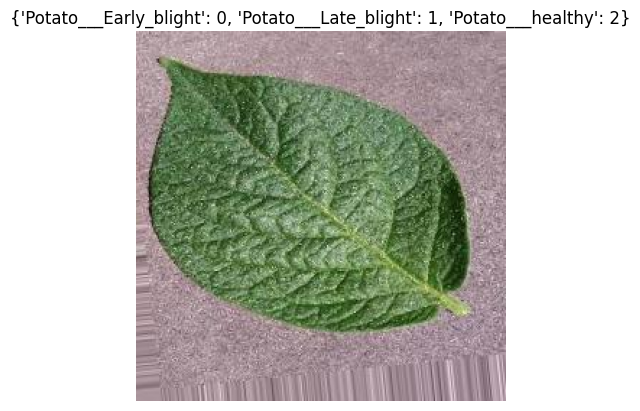

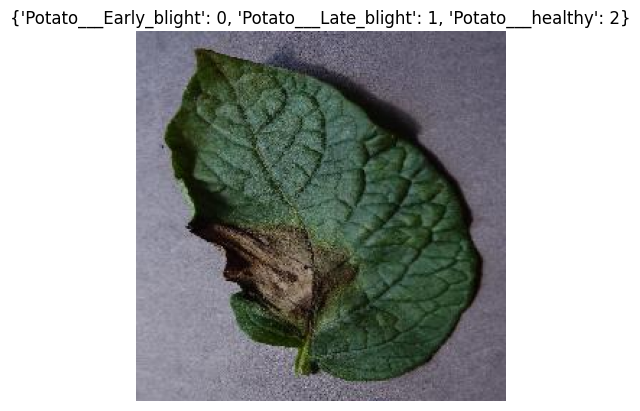

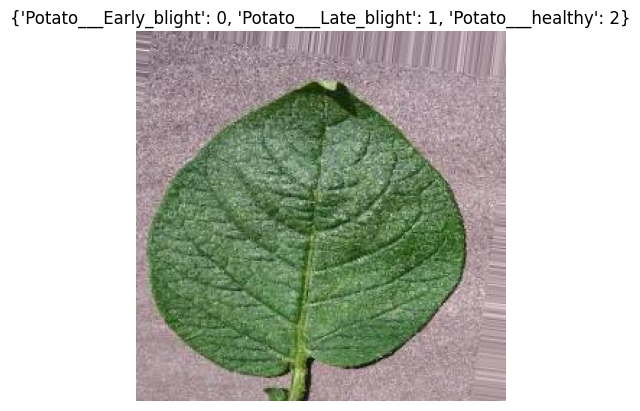

In [ ]:
#visualizing each instance of the training data
for i in range(3):
    plt.figure()
    plt.imshow(train_data[i][0][0])
    plt.title(train_data.class_indices)
    plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras.regularizers import l2


In [ ]:
model1=Sequential()
model1.add(Conv2D(64,(3,3),input_shape=(256,256,3),kernel_regularizer=l2(0.01),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128,(3,3),kernel_regularizer=l2(0.1),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(256, (3, 3),kernel_regularizer=l2(0.1), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(3,activation='softmax'))

In [ ]:
# compiling the model
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 256)       0

In [ ]:
history1 = model1.fit(
    train_data,
    epochs = 20,
    batch_size = 32,
    verbose = 1,
    validation_data = validation_data
)

Epoch 1/20
29/29 [==============================] - 21s 200ms/step - loss: 14.8702 - accuracy: 0.3789 - val_loss: 6.4621 - val_accuracy: 0.3767
Epoch 2/20
29/29 [==============================] - 7s 239ms/step - loss: 4.0504 - accuracy: 0.5433 - val_loss: 2.2636 - val_accuracy: 0.7700
Epoch 3/20
29/29 [==============================] - 4s 145ms/step - loss: 1.7476 - accuracy: 0.7900 - val_loss: 1.2069 - val_accuracy: 0.8467
Epoch 4/20
29/29 [==============================] - 4s 141ms/step - loss: 1.0572 - accuracy: 0.8222 - val_loss: 0.7818 - val_accuracy: 0.8867
Epoch 5/20
29/29 [==============================] - 5s 157ms/step - loss: 0.8005 - accuracy: 0.8511 - val_loss: 0.6416 - val_accuracy: 0.8733
Epoch 6/20
29/29 [==============================] - 4s 142ms/step - loss: 0.6446 - accuracy: 0.8656 - val_loss: 0.4419 - val_accuracy: 0.9300
Epoch 7/20
29/29 [==============================] - 4s 145ms/step - loss: 0.4453 - accuracy: 0.9178 - val_loss: 0.3860 - val_accuracy: 0.9100
Epoc

In [ ]:
results = model1.evaluate(validation_data, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.23631
Test Accuracy: 94.00%


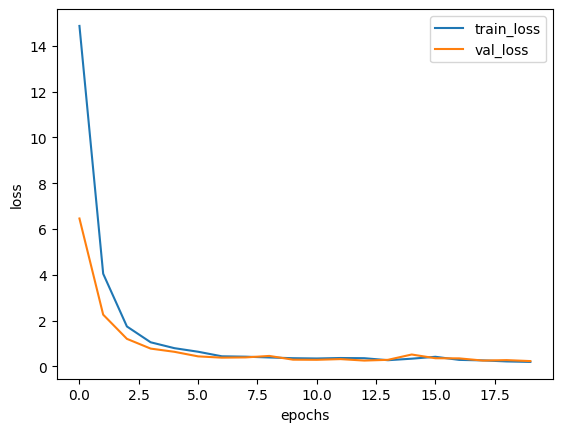

In [ ]:
# ploting the loss of the model
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

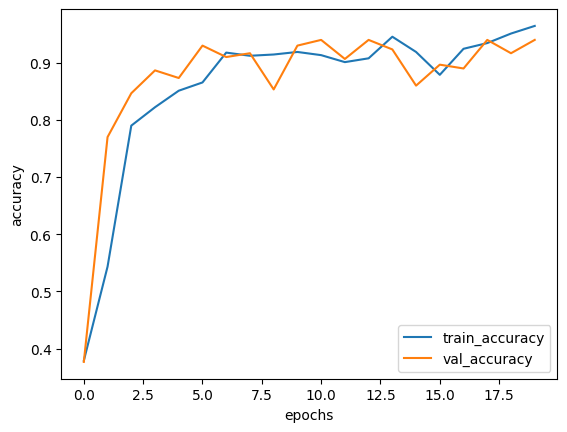

In [ ]:
# pllotiing the accuracy of the model
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## Building a model using pre-trained model (Resnet50)

In [ ]:
train_data = keras.utils.image_dataset_from_directory(
    directory = '/content/Potato/Train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_data = keras.utils.image_dataset_from_directory(
    directory = '/content/Potato/Valid',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    shuffle = False,
    image_size=(256,256)
)
test_data = keras.utils.image_dataset_from_directory(
    directory = '/content/Potato/Test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    shuffle = False,
    image_size=(256,256)
)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
def norm(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_data = train_data.map(norm)
test_data=test_data.map(norm)
validation_data = validation_data.map(norm)

In [ ]:
image_size=[256,256]
resnet=ResNet50(include_top=False,weights='imagenet',input_shape=image_size+[3])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:

# dont use the existing weight just use that is initilized in the resnet50
for layer in resnet.layers:
    layer.trainable=False

In [ ]:
# adding the flatten layers
X=Flatten()(resnet.output)

X=Dense(units=556,activation='relu')(X)

X=Dense(units=256,activation='relu')(X)

X=Dense(len(class_names),activation='softmax')(X)

model2=Model(inputs=resnet.input,outputs=X)

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_data,
    epochs = 20,
    batch_size = 32,
    verbose = 1,
    validation_data = validation_data
)

Epoch 1/20
29/29 [==============================] - 7s 253ms/step - loss: 9.6755 - accuracy: 0.3378 - val_loss: 0.9063 - val_accuracy: 0.5800
Epoch 2/20
29/29 [==============================] - 5s 173ms/step - loss: 1.2514 - accuracy: 0.5389 - val_loss: 1.3182 - val_accuracy: 0.5200
Epoch 3/20
29/29 [==============================] - 5s 178ms/step - loss: 1.1756 - accuracy: 0.6089 - val_loss: 0.7443 - val_accuracy: 0.6333
Epoch 4/20
29/29 [==============================] - 5s 178ms/step - loss: 0.7236 - accuracy: 0.7000 - val_loss: 0.9339 - val_accuracy: 0.6033
Epoch 5/20
29/29 [==============================] - 5s 182ms/step - loss: 0.8578 - accuracy: 0.6478 - val_loss: 0.9054 - val_accuracy: 0.6033
Epoch 6/20
29/29 [==============================] - 5s 177ms/step - loss: 0.7550 - accuracy: 0.6789 - val_loss: 1.1579 - val_accuracy: 0.5567
Epoch 7/20
29/29 [==============================] - 6s 184ms/step - loss: 0.7993 - accuracy: 0.7067 - val_loss: 1.4965 - val_accuracy: 0.4867
Epoch 

In [ ]:
## evaluate
results = model2.evaluate(validation_data, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.53881
Test Accuracy: 75.67%


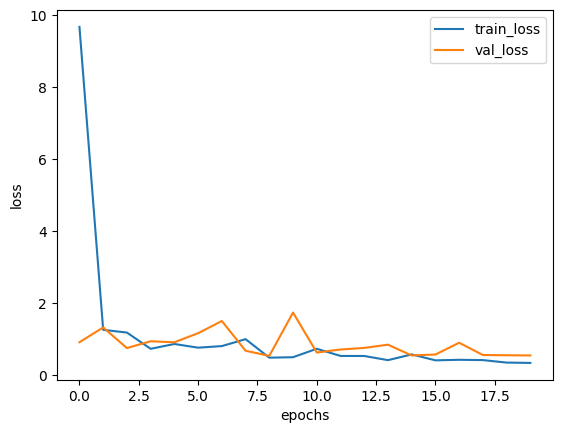

In [ ]:
# pllotiing the loss of the model
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


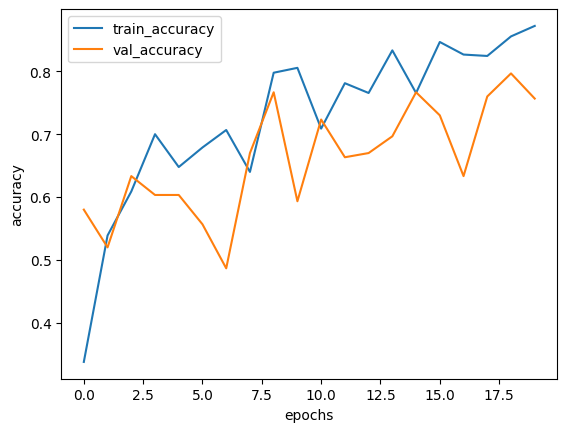

In [ ]:
# pllotiing the accuracy of the model
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## Comparing three models i.e 'model','model1' and 'model2' we get model1 as the better model. So we use model1 as our model.

In [ ]:
import pickle
pickle.dump(model1,open('potato_model.pkl','wb'))

In [ ]:
model1.save('potato_models.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#loading the model
potato=pickle.load(open('potato_model.pkl','rb'))



Enter the path of the image to be predicted:/content/Potato/Test/Potato___healthy/Potato_healthy-26-_0_9285.jpg


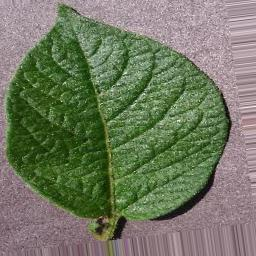

1/1 [==============================] - 0s 20ms/step
Predicted class: Potato___healthy


In [ ]:
# Making  a predictive system
input_image_path=input('Enter the path of the image to be predicted:')

input_image=cv2.imread(input_image_path)
input_image_resize=cv2.resize(input_image,(256,256))
input_image_resize = cv2.cvtColor(input_image_resize, cv2.COLOR_BGR2RGB)
input_image_scaled=input_image_resize/255.
input_image_reshaped=np.reshape(input_image_scaled,[1,256,256,3])
cv2_imshow(input_image)
input_prediction=potato.predict(input_image_reshaped)

input_pred_label=np.argmax(input_prediction)

predicted_class_label = class_names[input_pred_label]

print("Predicted class:", predicted_class_label)


In [ ]:
y_pred = model1.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 [==============================] - 1s 48ms/step


In [ ]:
y_pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2])

In [ ]:
y_pred=np.argmax(y_pred)

In [ ]:
y_pred

138

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report


In [ ]:

true_labels = []
for images, labels in validation_data:
    true_labels.extend(labels.numpy())

print(true_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
cm = confusion_matrix(true_labels, y_pred_classes)
report=classification_report(true_labels, y_pred_classes)

In [ ]:
print(cm)

[[94  6  0]
 [ 1 91  8]
 [ 0  6 94]]


In [ ]:
report

'              precision    recall  f1-score   support\n\n           0       0.99      0.94      0.96       100\n           1       0.88      0.91      0.90       100\n           2       0.92      0.94      0.93       100\n\n    accuracy                           0.93       300\n   macro avg       0.93      0.93      0.93       300\nweighted avg       0.93      0.93      0.93       300\n'

Text(0.5, 1.0, 'Confusion Matrix')

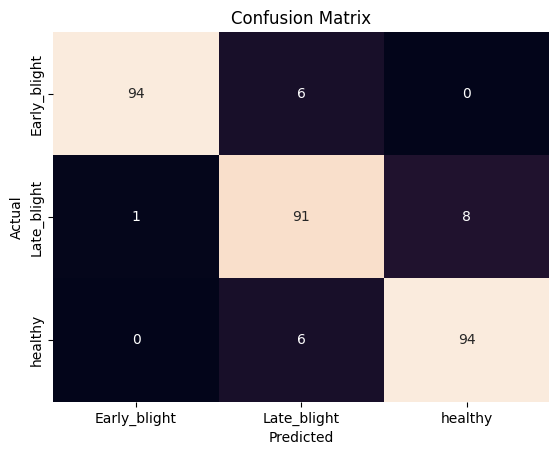

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True,cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=["Early_blight", "Late_blight","healthy"])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=["Early_blight", "Late_blight","healthy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")